In [16]:
import pandas as pd
import os
import numpy as np
import logging
import sys
import torch
import copy
import yaml
import random

from prediction_utils.pytorch_utils.metrics import (
    StandardEvaluator,
    FairOVAEvaluator,
    CalibrationEvaluator
)

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.set_style("ticks")



EXPERIMENT_NAME = 'apr14_thr'
args = {'experiment_name': EXPERIMENT_NAME,
        'cohort_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts/cohort/all_cohorts.csv',
        'base_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts',
        'plot_path': os.path.join('/labs/shahlab/projects/agataf/fairness_utility/eval/plots', EXPERIMENT_NAME)
       }

aggregate_path = os.path.join(args['base_path'], 'experiments', 
                              EXPERIMENT_NAME, 'performance',
                              'all')

experiment_plot_path = args['plot_path']
#os.makedirs(experiment_plot_path, exist_ok = True)

preds = pd.read_csv(os.path.join(aggregate_path, 'predictions.csv'))

eval_fold = 'val'

def get_calib_probs(model, x, transform=None):
    
    if transform=='log':
        model_input = np.log(x)
    else:
        model_input = x
        
    calibration_density = model.predict_proba(model_input.reshape(-1, 1))[:, -1]
                    
    df = pd.DataFrame({'pred_probs': x,
                       'model_input': model_input,
                       'calibration_density': calibration_density})  
    return df
    
def get_calib_model(preds_test, transform=None):
    
    evaluator = CalibrationEvaluator()
    _, model = evaluator.get_calibration_density_df(preds_test.labels,
                                                     preds_test.pred_probs,
                                                     preds_test.weights,
                                                     transform = transform)

    return model

def plot_calibration(calibration_df, zoom=False, output_path=None):    
    df = calibration_df.assign(group = lambda x: x.group.map(grp_label_dict))
    g = sns.relplot(data = df,
                    x = 'pred_probs',
                    y = 'calibration_density',
                    kind = 'line',
                    hue = 'group',
                    row = 'lambda_reg',
                    legend = True,
                    ci='sd',
                    err_style='bars',
                    aspect = 1.2)
    axes = g.axes.flatten()
    for ax in axes:
        ax.axline(xy1 = (0,0), slope = 1, color = "b", dashes = (5, 2), label = "Perfectly calibrated")
        ax.axvline(x = 0.075, linestyle = '--', color = 'grey')
        ax.axvline(x = 0.2,   linestyle = '--', color = 'grey')
        ax.axhline(y = 0.075, linestyle = '--', color = 'grey')
        ax.axhline(y = 0.2,   linestyle = '--', color = 'grey')

        if zoom:
            ax.set(xlim = (0, 0.25), ylim = (0, 0.25))
        else:
            ax.set(xlim = (0, 1), ylim = (0, 1))

        ax.set_xlabel("predicted risk")
        ax.set_ylabel("fraction of positives")
    
    if output_path is not None:
        g.savefig(output_path)

In [21]:
def calc_score(model, x, y, sample_weight=None, transform=None):
    x = x.values.reshape(-1, 1)
    y = y.values.reshape(-1, 1)
    if transform=='log':
        x = np.log(x)
    
    y_preds = model.predict_proba(x)[:,-1]
    
    brier = brier_score_loss(y_true = y,
                       y_prob = y_preds,
                       sample_weight=sample_weight)

    logloss = log_loss(y_true = y,
                       y_pred = y_preds,
                       sample_weight=sample_weight
                      )

    return brier, logloss

In [ ]:
fit_calibration_bootstrap=True

if fit_calibration_bootstrap:
    df_to_calibrate = preds.query("phase=='test'").reset_index(drop=True)
    lin_calibs=[]
    thr_calibs=[]
    for group in [1,2,3,4]:
        for lambda_reg in preds.lambda_reg.unique():
            max_pred_prob = df_to_calibrate.query("(group==@group) & (lambda_reg==@lambda_reg)").pred_probs.values.max()
            for fold_id in range(1,11): 
                for iter in range(100):
                    loop_kwargs = {'group': group,
                                   'lambda_reg': lambda_reg,
                                   'fold_id': fold_id}
                    
                    group_df = (df_to_calibrate
                                .query("(group==@group) & (fold_id==@fold_id) & (lambda_reg==@lambda_reg)")
                                .sample(frac=1, replace=True)
                               )

                    model = get_calib_model(group_df, transform='log')
                    
                    lin_calib = (get_calib_probs(model, np.linspace(1e-15, max_pred_prob, 30), 'log')
                                 .assign(**loop_kwargs))
                    lin_calibs.append(lin_calib)
                    
                    thr_calib = (get_calib_probs(model, [0.075, 0.2], 'log')
                                 .assign(**loop_kwargs))
                    thr_calibs.append(thr_calib)
                
                print(group,fold_id,lambda_reg)

    lin_calibs = pd.concat(lin_calibs)
    lin_calibs.to_csv(os.path.join(aggregate_path, 'calibration_sensitivity_test_raw.csv'), index=False)

    thr_calibs = pd.concat(thr_calibs)
    thr_calibs.to_csv(os.path.join(aggregate_path, 'calibration_sensitivity_thresholds_raw.csv'), index=False)
    
else:
    lin_calibs_initial = pd.read_csv(os.path.join(aggregate_path, 'calibration_sensitivity_test_raw.csv'))
    thr_calibs_final = pd.read_csv(os.path.join(aggregate_path, 'calibration_sensitivity_thresholds_raw.csv'))
    

1 1 0.001
1 2 0.001
1 3 0.001
1 4 0.001
1 5 0.001
1 6 0.001
1 7 0.001
1 8 0.001
1 9 0.001
1 10 0.001
1 1 0.0021544346900318843
1 2 0.0021544346900318843
1 3 0.0021544346900318843
1 4 0.0021544346900318843
1 5 0.0021544346900318843
1 6 0.0021544346900318843
1 7 0.0021544346900318843
1 8 0.0021544346900318843
1 9 0.0021544346900318843
1 10 0.0021544346900318843
1 1 0.004641588833612777
1 2 0.004641588833612777
1 3 0.004641588833612777
1 4 0.004641588833612777
1 5 0.004641588833612777
1 6 0.004641588833612777
1 7 0.004641588833612777
1 8 0.004641588833612777
1 9 0.004641588833612777
1 10 0.004641588833612777
1 1 0.01
1 2 0.01
1 3 0.01
1 4 0.01
1 5 0.01
1 6 0.01
1 7 0.01
1 8 0.01
1 9 0.01
1 10 0.01
1 1 0.021544346900318832
1 2 0.021544346900318832
1 3 0.021544346900318832
1 4 0.021544346900318832
1 5 0.021544346900318832
1 6 0.021544346900318832
1 7 0.021544346900318832
1 8 0.021544346900318832
1 9 0.021544346900318832
1 10 0.021544346900318832
1 1 0.046415888336127774
1 2 0.04641588833612

In [26]:
lin_calibs_initial

,Unnamed: 0,pred_probs,model_input,calibration_density,group,lambda_reg,fold_id
0,0,1.000000e-15,-34.538776,2.519086e-17,1,0.001,1
1,1,2.545032e-02,-3.671027,1.552838e-02,1,0.001,1
2,2,5.090064e-02,-2.977880,3.278762e-02,1,0.001,1
3,3,7.635097e-02,-2.572415,5.036264e-02,1,0.001,1
4,4,1.018013e-01,-2.284733,6.790670e-02,1,0.001,1
...,...,...,...,...,...,...,...
1199995,25,1.641667e-01,-1.806873,6.575736e-01,4,1.000,10
1199996,26,1.707333e-01,-1.767652,6.956858e-01,4,1.000,10
1199997,27,1.773000e-01,-1.729912,7.299944e-01,4,1.000,10
1199998,28,1.838667e-01,-1.693544,7.606505e-01,4,1.000,10


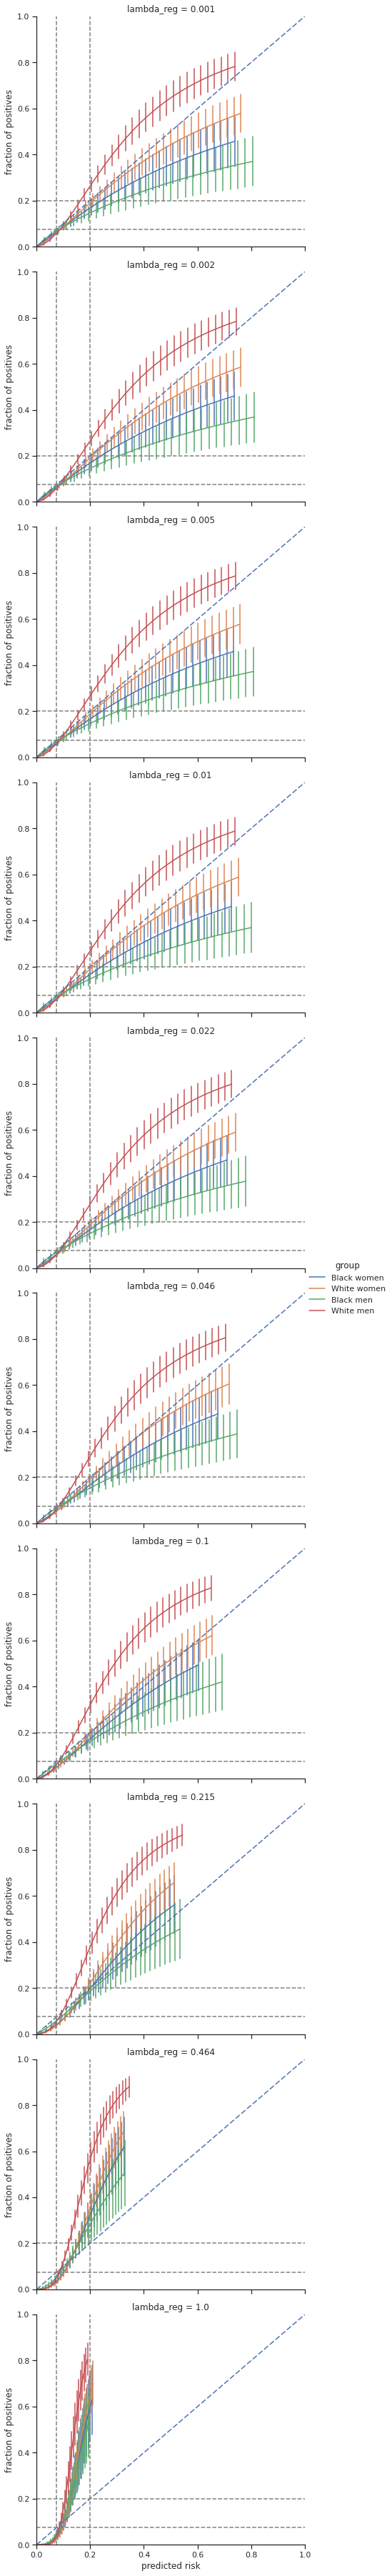

In [27]:
grp_label_dict = {1: 'Black women', 2: 'White women', 3: 'Black men', 4: 'White men'} 


output_path = os.path.join(args['plot_path'], 'calibrations.png')
df = lin_calibs_initial.assign(lambda_reg = lambda x: x.lambda_reg.round(3))

plot_calibration(df, zoom=False, output_path=output_path)

In [ ]:
    a = thr_calibs_final.assign(group = lambda x: x.group.map(grp_label_dict))
    output_path = os.path.join(args['plot_path'], 'real_thresholds.png')
    
    
    g = sns.relplot(data = a,
                    x = 'lambda_reg',
                    y = 'calibration_density',
#                     row = 'group',
                     col = 'pred_probs',
#                     kind = 'line',
                   hue = 'group',
                    facet_kws = {'sharey': False, 'sharex': False},# 'margin_titles': True},
                    legend = True,
                    ci='sd',
                    kind="line",
                    err_style='bars',
                    aspect = 1.2)
    axes = g.axes.flatten()
    axes[0].axhline(y = 0.075, linestyle = '--', color = 'grey')

    axes[1].axhline(y = 0.075, linestyle = '--', color = 'grey')
    axes[1].axhline(y = 0.2,   linestyle = '--', color = 'grey')
        
    if output_path is not None:
        g.savefig(output_path)

In [ ]:
## (TODO): get fit information


#                 score, logloss = calc_score(model, 
#                                             x = preds_test.pred_probs,
#                                             y = preds_test.labels, 
#                                             sample_weight = preds_test.weights,
#                                             transform = transform)
#                 fits.append({'score': score,
#                              'logloss': logloss,
#                              'fold_id': fold_id,
#                              'config_id': config_id,
#                              'group': group}
#                            )

calibrations_df_logx, fits_df_logx = calc_calibration(preds, num_configs, transform='log')

sns.relplot(data = fits_logreg,
            x = 'config_id',
            y = 'score',
            kind = 'line',
            hue = 'group',
            facet_kws = {'sharey': True, 'sharex': True},
            legend = True,
            aspect = 1.2)

In [15]:
calib_dfs = []
for config_id in range(num_configs):
    for group in range(1,5):
        preds_test_grp = preds.query("(phase=='test') \
                    & (config_id==@config_id) \
                    & (group==@group)")
        for fold_id in range(1,11):
            preds_test = preds_test_grp.query("fold_id==@fold_id")
            lambda_reg = preds_test.lambda_reg.unique()[0]
                
            #preds_test = preds_test_grp.query("fold_id==@fold_id")
            
            evaluator = BinningEstimator(num_bins=10)
            evaluator.fit(x = preds_test.pred_probs.values,
                          y = preds_test.labels.values,
                          sample_weight = preds_test.weights.values
                         )
            pred_calib = evaluator.predict_proba(preds_test.pred_probs.values)
            
            df_synth = pd.DataFrame({"pred_probs": np.linspace(0,preds_test_grp.pred_probs.max(), 30)})    

            calibration_density = evaluator.predict_proba(df_synth.pred_probs.values.reshape(-1, 1))
        
            if len(calibration_density.shape) > 1:
                calibration_density = calibration_density[:, -1]
            df_synth1 = (df_synth
                        .assign(calibration_density=calibration_density)
                        .groupby(['calibration_density'])
                        .mean()
                        .reset_index()
                        .assign(config_id=config_id,
                                group=group,
                                fold_id=fold_id,
                                lambda_reg = str(round(lambda_reg, 3)))
                               #lambda_reg=str(lambda_reg))
                       )
            calib_dfs.append(df_synth1)
            


calibrations_bins = (pd
                      .concat(calib_dfs)
                      .assign(is_male = lambda x: np.where((x.group == 3) | (x.group == 4), 1, 0),
                              is_white = lambda x: np.where((x.group == 2) | (x.group == 4), 1, 0))
                     )

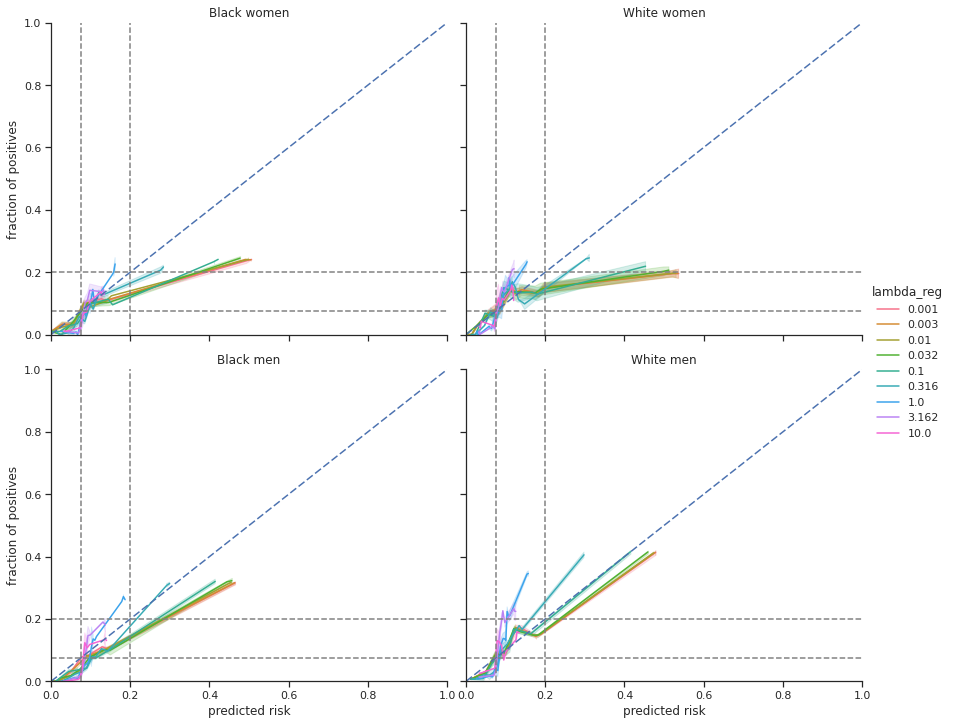

In [16]:
plot(calibrations_bins, output_path = os.path.join(experiment_plot_path, 'calibration_bins.png'))

In [17]:
calibrations_bins.groupby(['group', 'pred_probs']).std().query('group==1').calibration_density

group  pred_probs
1      0.000000      0.000007
       0.011101      0.000086
       0.014186      0.003282
       0.021279           NaN
       0.022203      0.000008
                       ...   
       0.490275           NaN
       0.492002      0.006723
       0.498370      0.006436
       0.504282      0.003185
       0.506059      0.000098
Name: calibration_density, Length: 88, dtype: float64

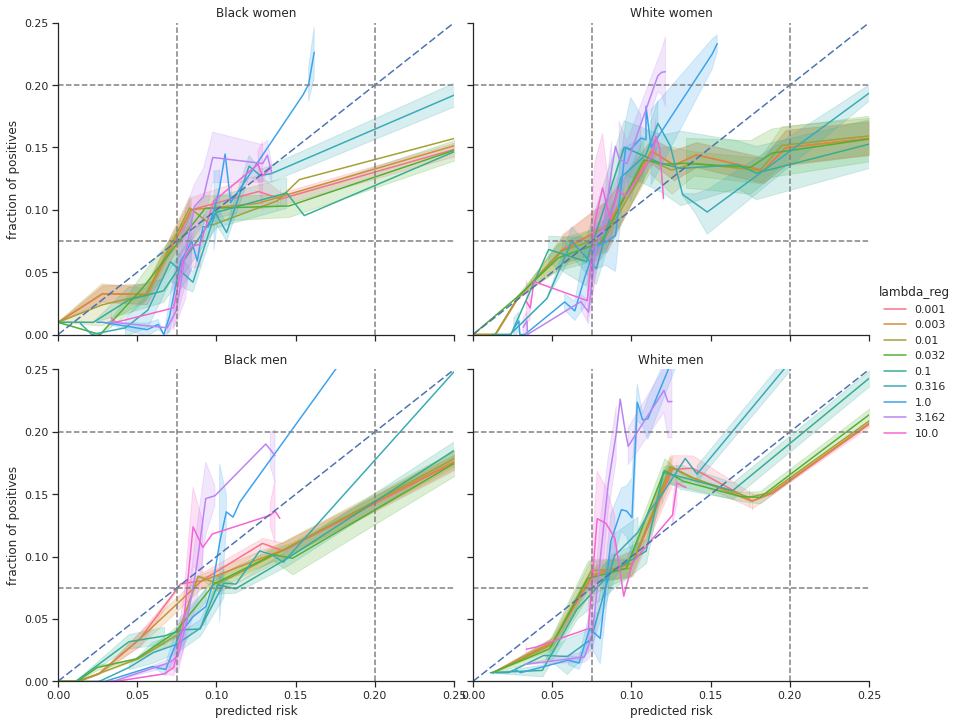

In [18]:
plot(calibrations_bins, zoom=True, output_path = os.path.join(experiment_plot_path, 'calibration_bins_zoom.png'))